In [667]:
# Import packages
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import statsmodels.api as sm

### Data Collection

In [668]:
# Data Collection
# Data files and codebook from: https://www.eia.gov/consumption/residential/data/2015/index.php?view=microdata

# Load and Preview DataFrame
df = pd.read_csv('recs2015.csv')
df = df.set_index(['DOEID'])

# Create feature for electric rate; total electric cost is likely unknown when trying to predict kWH, but electric rate is generally known for each region.
df['ELRATE'] = df['DOLLAREL']/df['KWH']

### Data Definition

In [669]:
# Inspect dataframe
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5686 entries, 10001 to 15686
Columns: 759 entries, REGIONC to ELRATE
dtypes: float64(263), int64(492), object(4)
memory usage: 33.0+ MB
None


,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,...,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT,ELRATE
DOEID,,,,,,,,,,,,,,,,,,,,,
10001,4,10,METRO,U,2,0,0,0,-2,-2,...,103.32,1,0,137.45,-2,-2,91.33,-2,-2,0.183509
10002,3,7,NONE,R,2,0,0,0,-2,-2,...,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2,0.112216
10003,3,6,METRO,U,2,0,1,0,1,0,...,100.14,1,0,137.45,-2,-2,91.33,-2,-2,0.123533
10004,2,4,MICRO,C,2,0,1,0,1,0,...,NaN,-2,-2,137.45,-2,-2,91.33,2,0,0.133277
10005,1,2,METRO,U,2,0,1,0,0,0,...,102.83,1,0,137.45,-2,-2,91.33,-2,-2,0.186500


,0,1,2,3,4,5,6,7,8,9,...,749,750,751,752,753,754,755,756,757,758
Feature,USEEL,ZTYPEHUQ,LPXBTU,ELXBTU,ELOTHER,ZFOODPROC,RICECOOK,ZRICECOOK,BLENDER,ZBLENDER,...,KWH,TOTALBTUWTH,KWHNEC,BTUEL,KWHLGT,BTUELNEC,TOTALBTUNEC,TOTALBTU,BTUELLGT,ELRATE
Count_Unique,1,1,1,1,1,2,2,2,2,2,...,5665,5672,5677,5680,5681,5682,5683,5684,5685,5686


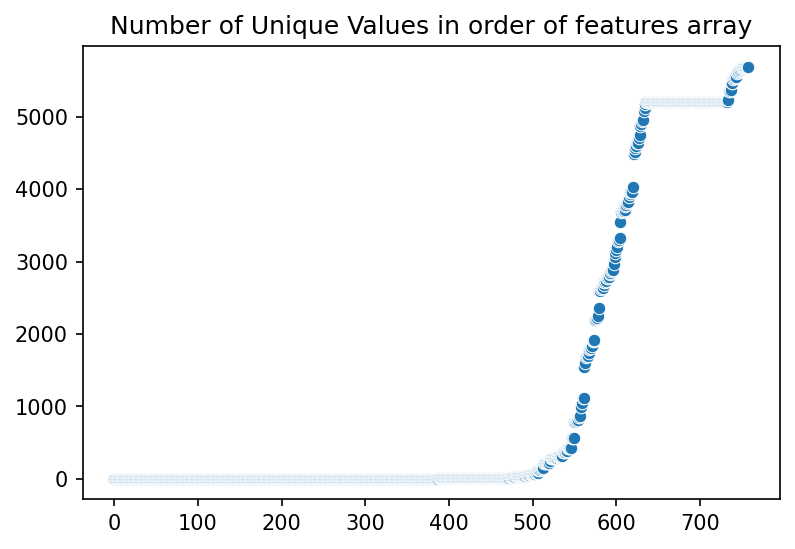

In [670]:
# The dataframe has many categorical variables encoded as numeric. Use sorted list to help identify categorical variables
x0 = np.arange(len(df.columns))
features = df.nunique().sort_values().index
counts = df.nunique().sort_values()

sns.scatterplot(x=x0, y=counts)
plt.title('Number of Unique Values in order of features array')
pd.DataFrame([features, counts], index=['Feature','Count_Unique'])

### Data Cleaning

#### Eliminate Extraneous Features

The following features of the original dataset are not expected to be predictive and were manually grouped into lists.

* Imputation flags: describes whether variables were imputed from survey forms
* Conversion factors: constants representing conversion of one form of energy to another
* Other utilities: total consumption of propane, fuel oil, and natural gas, as well as estimates of end-use consumption for specific activities usch as clothes washing based on survey responses
* Estimators: replicate sample estimates from Fay’s method of the balanced repeated replication (BRR) technique for calculating standard error
* Redundant variables: Expected to be highly colinear with others. An example is HDD50; which is a scaling factor used to calculate required heat to bring building temperature to 50 degrees Fahrenheit, when the dataset already contains HDD65 -- the same thing but for a 65 degree F temperature.
* Detailed: Variables that are likely not known for most buildings because they would require a detailed audit
* Miscellaneous: Other variables manually reviewed which are not expected to affect KWH; example is move-in date

In [671]:
# Read in lists of non-predictive features
impute0 = pd.read_excel('Data Cleaning/imputation_flags.xlsx')['Variable']
conversion0 = pd.read_excel('Data Cleaning/conversion_factors.xlsx')['Variable']
other_utilities0 = pd.read_excel('Data Cleaning/other_utilities.xlsx')['Variable']
estimators0 = pd.read_excel('Data Cleaning/statistical_estimators.xlsx')['Variable']
utility_costs0 = pd.read_excel('Data Cleaning/utility_costs.xlsx')['Variable']
redundant0 = pd.read_excel('Data Cleaning/redundant_vars.xlsx')['Variable']
detailed0 = pd.read_excel('Data Cleaning/detailed_audit.xlsx')['Variable']
miscellaneous0 = pd.read_excel('Data Cleaning/miscellaneous_not_used.xlsx')['Variable']

#### Set aside potential cluster variables

There are many variables describing tenant-behavior, energy star appliances, and demographic information. These are not expected to be significant on their own but in combination may be useful for clustering; for example to categorize resident activity as low/medium/high.

In [672]:
# Read in lists of similar predictive features that may work better as clusters or principal components
tenant_behavior_c = pd.read_excel('Data Cleaning/tenant_behavior_cluster.xlsx')['Variable']
energy_star_c = pd.read_excel('Data Cleaning/energy_star_cluster.xlsx')['Variable']
energy_assistance_c = pd.read_excel('Data Cleaning/energy_assistance_cluster.xlsx')['Variable']

In [673]:
# Combine nonpredictive features into a single list
nonpredict = np.concatenate((impute0, conversion0, other_utilities0, estimators0, utility_costs0, miscellaneous0, redundant0, detailed0), axis=0)

In [674]:
# Combine clusters into list to be temporarily dropped
clustervars = np.concatenate((tenant_behavior_c, energy_star_c, energy_assistance_c), axis=0)

In [675]:
# Drop nonpredictive features
df = df.drop(nonpredict, axis=1)

# Drop cluster variables
df = df.drop(clustervars, axis=1)

#### -->Inspect Resulting Dataframe

In [676]:
# Count missing values using keys from documentation: {'Not applicable': -2, 'Don't Know': -9, 'Refuse': -8}

# Create mask for each type of missing value
na_mask = df.apply(lambda x: x==-2)
dk_mask = df.apply(lambda x: x==-9)
refuse_mask = df.apply(lambda x: x==-8)

In [677]:
# Count number of instances where mask is True
na = df[na_mask].count()[df[na_mask].count() > 0]
dk = df[dk_mask].count()[df[dk_mask].count() > 0]
refuse = df[refuse_mask].count()[df[refuse_mask].count() > 0]

print(str(len(na.index)) + ' columns containing \"Not applicable\" values.')
print(str(len(dk.index)) + ' columns containing \"Dont know\" values.')
print(str(len(refuse.index)) + ' columns containing \"Refuse\" values.')

48 columns containing "Not applicable" values.
4 columns containing "Dont know" values.
2 columns containing "Refuse" values.


#### -->Replace Negatives Representing Missing Values

In [678]:
# Replace negative values for binary variables (i.e. where negatives are "not applicable")

# Read in binary variables
binaryvars = pd.read_excel('Data Cleaning/binary_vars.xlsx')['Variable']

# Filter out negative values ("Not applicable" means approximately the same as "no" or "does not have" for binary variables)
df[binaryvars] = df[binaryvars].apply(lambda x: (x>0)*x)

#### -->Make Categorical Variables Dummy Variables

In [679]:
# Create dummy variables for columns with missing answers, making the missing values the base case.

# Read in list of categorical variables
cat_vars = pd.read_excel('Data Cleaning/categorical_vars.xlsx')['Variable']

In [680]:
df = pd.get_dummies(df.astype(str), columns=cat_vars, drop_first=True, prefix=cat_vars).astype('float64')

In [681]:
# Check missing values
print(df.isna().sum().max())

# Inspect DataFrame
df.shape

0


(5686, 228)

#### -->Reinspect Missing Values

In [682]:
# Create mask for each type of missing value
na_mask = df.apply(lambda x: x==-2)
dk_mask = df.apply(lambda x: x==-9)
refuse_mask = df.apply(lambda x: x==-8)

# Count number of instances where mask is True
na = df[na_mask].count()[df[na_mask].count() > 0]
dk = df[dk_mask].count()[df[dk_mask].count() > 0]
refuse = df[refuse_mask].count()[df[refuse_mask].count() > 0]

print(str(len(na.index)) + ' columns containing \"Not applicable\" values:')
print(na.index)
print(str(len(dk.index)) + ' columns containing \"Dont know\" values:')
print(dk.index)
print(str(len(refuse.index)) + ' columns containing \"Refuse\" values:')
print(refuse.index)

2 columns containing "Not applicable" values:
Index(['NUMBERAC', 'NUMWHOLEFAN'], dtype='object')
0 columns containing "Dont know" values:
Index([], dtype='object')
0 columns containing "Refuse" values:
Index([], dtype='object')


In [683]:
# Replace remaining "not applicable" negatives for number of AC units and number of whole house fans with zeros
df[na.index] = df[na.index].apply(lambda x: (x>0)*x)

# Remap responses to make near-ordinal variables ordinal: LGTINCFL and LGTINLED responses represent portion of lighting having CFL and LED bulbs on scale of "all" to "none"
# The "0" should be the highest value
df['LGTINCFL'][df['LGTINCFL'] == 0] = df['LGTINCFL'][df['LGTINCFL'] == 0].apply(lambda x: 5)
df['LGTINLED'][df['LGTINLED'] == 0] = df['LGTINCFL'][df['LGTINCFL'] == 0].apply(lambda x: 5)

In [684]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5686 entries, 10001 to 15686
Columns: 228 entries, CELLAR to WWACAGE_5
dtypes: float64(228)
memory usage: 10.1 MB


In [685]:
# Drop any other missing values
df.dropna(inplace=True)

### Dimension Reduction (Preliminary)

In [686]:
# Import sklearn packages

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [687]:
# Split Data
X = df.drop('KWH', axis=1)
names = df.drop('KWH', axis=1).columns
y = df['KWH']

#### -->Lasso Regression

In [688]:
# Lasso: Reduce dimensionality of dataset and print feature names.

lasso = Lasso(alpha=1, max_iter=1000, normalize=True)
lasso_coef = lasso.fit(X,y).coef_
coef = pd.DataFrame(lasso_coef, names)
coef_names = coef[coef[0]>0].index
print(coef_names)

Index(['ATTIC', 'NCOMBATH', 'NHAFBATH', 'HIGHCEIL', 'WINDOWS', 'ADQINSUL',
       'SWIMPOOL', 'RECBATH', 'BACKUP', 'NUMFRIG', 'NUMFREEZ', 'STOVEN',
       'STOVE', 'OVEN', 'DRYER', 'GARGHEAT', 'AIRCOND', 'CENACHP', 'NUMBERAC',
       'GARGCOOL', 'MORETHAN1H2O', 'LGTINCFL', 'LGTINLED', 'NHSLDMEM',
       'NUMADULT', 'MONEYPY', 'ELWARM', 'ELCOOL', 'ELFOOD', 'TOTCSQFT',
       'TOTSQFT_EN', 'CDD65', 'REGIONC_3', 'METROMICRO_MICRO',
       'METROMICRO_NONE', 'UATYP10_R', 'TYPEHUQ_2', 'STORIES_10', 'KOWNRENT_3',
       'WALLTYPE_7', 'ROOFTYPE_3', 'ROOFTYPE_4', 'ROOFTYPE_7', 'FUELPOOL_1',
       'FUELPOOL_5', 'FUELTUB_2', 'FUELTUB_21', 'FUELTUB_5', 'FUELTUB_8',
       'STOVENFUEL_2', 'STOVEFUEL_2', 'OVENFUEL_2', 'OVENFUEL_5', 'DRYRFUEL_5',
       'EQUIPM_4', 'EQUIPM_6', 'FUELHEAT_21', 'FUELHEAT_5', 'EQUIPAUXTYPE_2',
       'FUELAUX_2', 'COOLTYPE_3', 'FUELH2O_5', 'FUELH2O_8', 'WHEATSIZ_3',
       'FUELH2O2_1', 'FUELH2O2_5', 'FUELH2O2_7', 'ELPAY_2', 'ELPAY_3',
       'ELPAY_9', 'IECC_CLIMATE_P